In [8]:
!python -V

Python 3.9.16


In [3]:
import pandas as pd

In [4]:
import pickle


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [10]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiement")

2023/05/26 14:23:35 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiement' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/sarveshthakur/Documents/MLOps Zoomcamp/experiment_tracking/mlruns/1', creation_time=1685125415921, experiment_id='1', last_update_time=1685125415921, lifecycle_stage='active', name='nyc-taxi-experiement', tags={}>

In [11]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet

zsh:1: command not found: wget


In [12]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet

zsh:1: command not found: wget


In [13]:
!pip install pyarrow

In [28]:
df = pd.read_parquet('~/Documents/MLOps Zoomcamp/data/green_tripdata_2022-01.parquet')

In [29]:
df.shape

(62495, 20)

In [30]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75


In [37]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 49)]


In [38]:
len(df)

59119

In [39]:
df.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
count,59119.000000,59119,59119,52963.000000,59119.000000,59119.000000,52963.000000,59119.000000,59119.000000,59119.000000,59119.000000,59119.000000,59119.000000,59119.000000,59119.000000,52963.000000,52963.000000,52963.000000,59119.000000
mean,1.851503,2022-01-16 15:47:22.362303232,2022-01-16 16:01:08.489216768,1.128316,96.459920,135.773998,1.261201,77.448959,13.259947,0.357313,0.434437,1.668627,0.193636,0.298681,16.864792,1.392161,1.024413,0.736004,13.768782
min,1.000000,2021-12-31 19:42:09,2021-12-31 19:48:26,1.000000,1.000000,1.000000,0.000000,0.000000,-65.000000,-1.000000,-0.500000,-0.070000,-6.550000,-0.300000,-71.850000,1.000000,1.000000,0.000000,1.000000
25%,2.000000,2022-01-08 23:03:11.500000,2022-01-08 23:15:16,1.000000,52.000000,74.000000,1.000000,1.150000,7.000000,0.000000,0.500000,0.000000,0.000000,0.300000,9.360000,1.000000,1.000000,0.000000,7.350000
50%,2.000000,2022-01-16 15:41:44,2022-01-16 15:57:09,1.000000,75.000000,138.000000,1.000000,1.940000,10.500000,0.000000,0.500000,1.030000,0.000000,0.300000,13.810000,1.000000,1.000000,0.000000,11.716667
75%,2.000000,2022-01-24 09:04:44,2022-01-24 09:18:03.500000,1.000000,129.000000,215.000000,1.000000,3.500000,16.285000,0.500000,0.500000,2.640000,0.000000,0.300000,20.570000,2.000000,1.000000,2.750000,18.000000
max,2.000000,2022-01-31 23:57:37,2022-02-01 00:26:00,5.000000,265.000000,265.000000,8.000000,224481.380000,250.000000,4.500000,0.500000,60.800000,39.040000,0.300000,262.050000,5.000000,2.000000,2.750000,49.000000
std,0.355595,NaN,NaN,0.699792,62.192738,77.350442,0.883114,2915.314127,9.465062,0.662908,0.170763,2.281314,1.192448,0.025907,11.208756,0.504031,0.154330,1.217508,8.762671


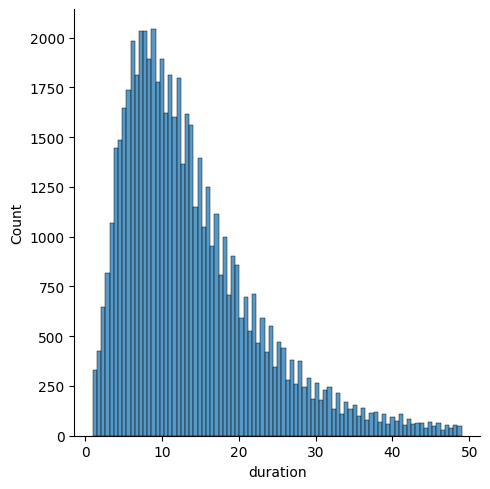

In [40]:
sns.displot(df.duration)

In [41]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    59119.000000
mean        13.768782
std          8.762671
min          1.000000
50%         11.716667
95%         31.700000
98%         38.844000
99%         42.830333
max         49.000000
Name: duration, dtype: float64

### Features


In [42]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical].dtypes
df[categorical] = df[categorical].astype(str)


/var/folders/fl/tyk3pbz53zbgy0w8f33qtz1c0000gn/T/ipykernel_98849/2306325525.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [43]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [44]:
train_dicts = df[categorical+numerical].to_dict(orient='records')

In [45]:
train_dicts

[{'PULocationID': '42', 'DOLocationID': '42', 'trip_distance': 0.44},
 {'PULocationID': '116', 'DOLocationID': '41', 'trip_distance': 2.1},
 {'PULocationID': '41', 'DOLocationID': '140', 'trip_distance': 3.7},
 {'PULocationID': '181', 'DOLocationID': '181', 'trip_distance': 1.69},
 {'PULocationID': '33', 'DOLocationID': '170', 'trip_distance': 6.26},
 {'PULocationID': '150', 'DOLocationID': '210', 'trip_distance': 1.3},
 {'PULocationID': '66', 'DOLocationID': '67', 'trip_distance': 6.47},
 {'PULocationID': '40', 'DOLocationID': '195', 'trip_distance': 1.15},
 {'PULocationID': '112', 'DOLocationID': '80', 'trip_distance': 1.3},
 {'PULocationID': '256', 'DOLocationID': '186', 'trip_distance': 4.75},
 {'PULocationID': '75', 'DOLocationID': '4', 'trip_distance': 6.03},
 {'PULocationID': '41', 'DOLocationID': '116', 'trip_distance': 2.82},
 {'PULocationID': '75', 'DOLocationID': '74', 'trip_distance': 0.7},
 {'PULocationID': '74', 'DOLocationID': '231', 'trip_distance': 7.54},
 {'PULocation

In [46]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [47]:
X_train

<59119x469 sparse matrix of type '<class 'numpy.float64'>'
	with 177357 stored elements in Compressed Sparse Row format>

In [48]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=148',

In [49]:
X_train.shape

(59119, 469)

In [50]:
len(dv.get_feature_names_out())

469

In [51]:
target = 'duration'
# target
y_train = df[target].values

## Training

## Linear Regression

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [53]:
y_pred = lr.predict(X_train)

/var/folders/fl/tyk3pbz53zbgy0w8f33qtz1c0000gn/T/ipykernel_98849/4107668193.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = 'prediction')
/var/folders/fl/tyk3pbz53zbgy0w8f33qtz1c0000gn/T/ipykernel_98849/4107668193.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, l

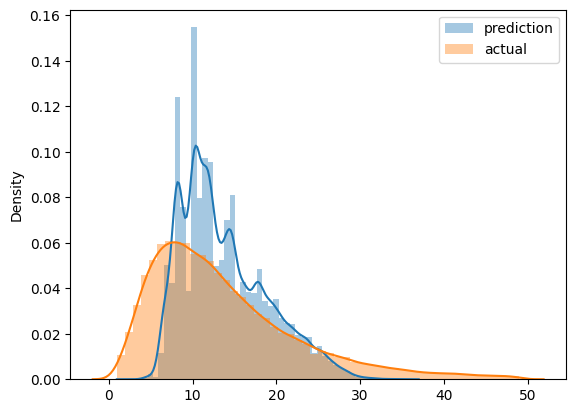

In [54]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

In [55]:
mean_squared_error(y_train, y_pred, squared=False)

7.110759340947752

In [62]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.pep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 39)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [63]:
df_train = read_dataframe('~/Documents/MLOps Zoomcamp/data/green_tripdata_2022-01.parquet')
df_val = read_dataframe('~/Documents/MLOps Zoomcamp/data/green_tripdata_2022-02.parquet')

In [64]:
len(df_train), len(df_val)

(57993, 63879)

In [65]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [66]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [67]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [71]:
with mlflow.start_run():

    mlflow.set_tag("developer", "st")

    mlflow.log_param("train-data-path", "'~/Documents/MLOps Zoomcamp/data/green_tripdata_2022-01.parquet'")
    mlflow.log_param("test-data-path", "'~/Documents/MLOps Zoomcamp/data/green_tripdata_2022-02.parquet'")
    

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred)

    mlflow.log_metric("rmse", rmse)

/var/folders/fl/tyk3pbz53zbgy0w8f33qtz1c0000gn/T/ipykernel_93603/4107668193.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = 'prediction')
/var/folders/fl/tyk3pbz53zbgy0w8f33qtz1c0000gn/T/ipykernel_93603/4107668193.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, l

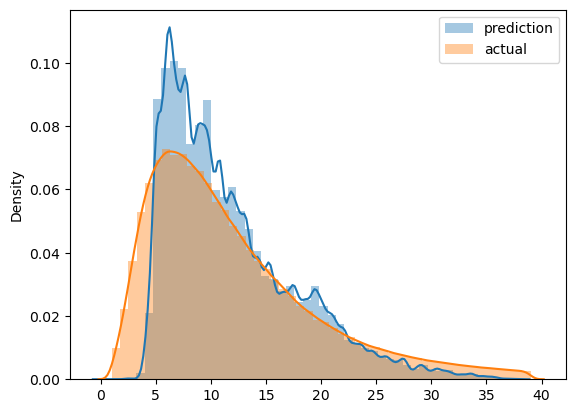

In [39]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

In [40]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)